# *checkpoint_schedule* application: Adjoint-Based Gradient with the Burger's Equation

This example shows adjoint-based gradient computation using the *checkpointing_schedules* package. We initially define the adjoint-based gradient problem and then present the forward and adjoint solvers prescribed by the *checkpointing_schedules* package.

## Defining the application

Let us consider a one-dimensional (1D) problem aiming to compute the gradient/sensitivity of the kinetic energy at a time $t=\tau$ with respect to an initial condition $u_0$. Then, our functional can be expressed as:
$$
I(u_0) = \frac{1}{2} u(x, \tau)u(x, \tau)
\tag{1}
$$

In the current case, the velocity variable $u = u(x, t)$ is governed by the 1D viscous Burgers equation, a non-linear equation for the advection and diffusion of momentum:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0.
\tag{2}
$$

Here, $x \in [0, L]$ is the space variable, and $t \in \mathbb{R}^{+}$ represents the time variable. The boundary condition is $u(0, t) = u(L, t) = 0$, where $L$ is the length of the 1D domain. The initial condition is given by $u_0 = \sin(\pi x)$.

The control parameter is the initial condition $u_0$. Hence, the objective is to compute the adjoint-based gradient of the functional $I(u_0)$ with respect to $u_0$.

This example uses the discrete adjoint formulation, meaning the adjoint system is from the discrete forward PDE system.

## Burger's equation solver
The sensitivity computation is performed by first solving the forward problem, and then using the forward solution to solve the adjoint problem. 

To solve the forward and adjoint problems, we define a `BurgersEquation` class that can be used to compute the forward and adjoint solutions. In addition, the `BurgersEquation` class defines a `copy_data` method that copies the data from one storage type to another, and an `adjoint_initial_condition` method that initializes the adjoint.

The forward Burger's equation is discretised using the Finite Element Method (FEM). We use continuous first-order Lagrange basis functions to discretise the spatial domain. The backward finite difference method is employed to discretise the equations in time.

After discretising, the forward system is written in the following form:
$$M \mathbf{U}^{n + 1} - M \mathbf{U}^{n} + \Delta t \left(C(\mathbf{U}^{n + 1}) \mathbf{U}^{n + 1} - K \mathbf{U}^{n + 1}\right) = 0,$$
where $M$ and $K$ are the mass and stiffness, respectively. $U$ represents the solution vector. The matrices $C$ is obtained from the convection term. The superscript $n$ denotes the time step, and $\Delta t$ is the time step size. The solution vector $\mathbf{U}^{n+1}$ is obtained by solving the non-linear forward system using the Newton method. 

In [1]:
import numpy as np
import os
from scipy.linalg import solve
from scipy.optimize import newton
import copy
from sympy import symbols, integrate, diff


class BurgersEquation:
    """A solver for the forward and adjoint one dimensional Burger's equation.

    Parameters
    ----------
    model : dict
        The model parameters containing the essential information to solve
        the Burger's equation.
    init_condition : array
        The initial condition used to solve the forward Burger's equation.
    mesh : array
        The spatial mesh.
    """
    def __init__(self, model, forward_initial_condition, mesh):
        self.model = model
        self.mesh = mesh
        self.forward_work_memory = {StorageType.WORK: {}}
        self.forward_work_memory[StorageType.WORK][0] = copy.deepcopy(forward_initial_condition)
        self.forward_final_solution = None
        self.adjoint_work_memory = {StorageType.WORK: {}}
        self.restart_forward = {StorageType.RAM: {}, StorageType.DISK: {}}
        self.adjoint_dependency = {StorageType.WORK: {}, StorageType.RAM: {}, StorageType.DISK: {}}
        self.mode = "forward"

    def forward(self, n0, n1, storage=None, write_adj_deps=False, write_ics=False):
        """Advance the forward solver.

        Parameters
        ----------
        n0 : int
            Initial time step.
        n1 : int
            Final time step.
        storage : StorageType, optional
            The storage type, which can be StorageType.RAM, StorageType.DISK,
            StorageType.WORK, or StorageType.NONE.
        write_adj_deps : bool, optional
            Whether the adjoint dependency data will be stored.
        write_ics : bool, optional
            Whether the forward restart data will be stored.
        """
        # Get the initial condition
        u = self.forward_work_memory[StorageType.WORK][n0]
        del self.forward_work_memory[StorageType.WORK][n0]
        if write_ics:
            self.restart_forward[storage][n0] = u.copy()
        n1 = min(n1, self.model["max_n"])
        step = n0
        while step < n1:
            def _residual(u_new):
                C = self._advection_matrix(u_new)
                M = self._mass_matrix()
                K = self._stiffness_matrix()
                residual = (M.dot(u_new) - M.dot(u))/self.model["dt"] + (K.dot(u_new) + C.dot(u_new))
                # Apply Dirichlet boundary conditions.
                residual[0] = residual[-1] = 0
                return residual
            if write_adj_deps:
                self.adjoint_dependency[storage][step] = copy.deepcopy(u)
            u_new = self._solve_newton(u, _residual, self._jacobian)
            u = copy.deepcopy(u_new)
            # print(u[0], u[-1])
            step += 1
        if step == self.model["max_n"]:
            self.forward_final_solution = copy.deepcopy(u_new)
        if (not write_adj_deps 
           or (self.mode == "forward" and step < (self.model["max_n"]))
        ):
            self.forward_work_memory[StorageType.WORK][step] = copy.deepcopy(u_new)

    def adjoint(self, n0, n1, clear_adj_deps):
        """Advance the adjoint solver.

        Parameters
        ---------
        n0 : int
            Initial time step.
        n1 : int
            Final time step.
        clear_adj_deps : bool
            If `True`, the adjoint dependency data will be cleared.
        """
        if n1 < self.model["max_n"]:
            u = self.adjoint_work_memory[StorageType.WORK][n1]
            del self.adjoint_work_memory[StorageType.WORK][n1]
        step = n1
        M = self._mass_matrix()
        M[0, :] = M[-1, :] = 0
        M[0, 0] = M[-1, -1] = 1
        while step > n0:
            adj_deps  = self.adjoint_dependency[StorageType.WORK][step-1]
            if step == self.model["max_n"]:
                d = copy.deepcopy(self.forward_final_solution)/self.model["dt"]
            else:
                d = M.dot(u)/self.model["dt"]
            A = self._jacobian(adj_deps).T
            A[0, :] = A[-1, :] = 0
            A[0, 0] = A[-1, -1] = 1
            u = solve(A, d)
            if clear_adj_deps:
                del self.adjoint_dependency[StorageType.WORK][step-1]
            step -= 1
        self.adjoint_work_memory[StorageType.WORK][step] = copy.deepcopy(u)

    def gradient(self):
        """Compute the adjoint-based gradient.

        Returns
        -------
        array
            The gradient.
        """
        M = self._mass_matrix()
        M[0, :] = M[-1, :] = 0
        M[0, 0] = M[-1, -1] = 1
        grad = M.dot(self.adjoint_work_memory[StorageType.WORK][0])
        return grad

    def copy_data(self, step, from_storage, to_storage, move=False, single_storage=False):
        """Copy data from one storage to another.

        Parameters
        ----------
        step : int
            The time step.
        from_storage : StorageType
            The storage type from which the data will be copied.
        to_storage : StorageType
            The storage type to which the data will be copied.
        move : bool, optional
            Whether the data will be moved or not. If `True`, the data will be
            removed from the `from_storage`.
        """
        if to_storage == StorageType.WORK:
            if single_storage:
                self.adjoint_dependency[StorageType.WORK][step] = self.adjoint_dependency[from_storage][step]
            else:
                self.forward_work_memory[StorageType.WORK][step] = self.restart_forward[from_storage][step]
        else:
            self.restart_forward[to_storage][step] = self.restart_forward[from_storage][step]
        if move:
            if single_storage:
                del self.adjoint_dependency[from_storage][step]
            else:
                del self.restart_forward[from_storage][step]
            
    def _jacobian(self, u):
        M = self._mass_matrix()
        K = self._stiffness_matrix()
        C = self._jacobian_advection(u)
        C1 = self._advection_matrix(u)
        Jac = M/self.model["dt"] + (K + C + C1)
        return Jac
    
    def _solve_newton(self, u_prev, residual, jacobian, tol=1e-6, max_iter=50):
        i = 0
        delta_u = 1
        u_prev[0] = u_prev[-1] = 0
        u_new = copy.deepcopy(u_prev)
        while i < max_iter:
            Jac = jacobian(u_new)
            # apply dirichlet boundary conditions.
            Jac[0, :] = Jac[self.model["nx"] - 1, :] = 0
            Jac[0, 0] = Jac[self.model["nx"] - 1, self.model["nx"] - 1] = 1
            delta_u = solve(Jac, residual(u_new))
            u_new -= delta_u
            i += 1
            if np.linalg.norm(delta_u) < tol:
                break
        if i == max_iter:
            print("Newton's method did not converge in {} iterations.".format(max_iter))
        return u_new

    def _mass_matrix(self):
        num_nodes = self.model["nx"]
        M = np.zeros((num_nodes, num_nodes))
        M[0, 0] = M[num_nodes - 1, num_nodes - 1] = 1/3
        M[0, 1] = M[num_nodes - 1, num_nodes - 2] = 1/6
        for i in range(1, num_nodes - 1):
            M[i, i - 1] = M[i, i + 1] = 1/6
            M[i, i] = 2/3
        return M
    
    def _stiffness_matrix(self):
        num_nodes = self.model["nx"]
        h = self.model["lx"] / self.model["nx"] 
        # 1D mesh is uniform. Thus, the mesh spacing is constant.
        b = self.model["nu"] / (h ** 2)
        K = np.zeros((num_nodes, num_nodes))
        K[0, 0] = K[num_nodes - 1, num_nodes - 1] = b
        K[0, 1] = K[num_nodes - 1, num_nodes - 2] = - b
        for i in range(1, num_nodes - 1):
            K[i, i - 1] = K[i, i + 1] = -b
            K[i, i] = + 2 * b
        return K
    
    def _advection_matrix(self, u):
        num_nodes = self.model["nx"]
        # Constant mesh spacing.
        u[0] = u[num_nodes - 1] = 0
        h = self.model["lx"] / self.model["nx"] 
        C = np.zeros((num_nodes, num_nodes))
        C[0, 0] = - u[0] / 3  - u[1] / 6
        C[0, 1] = - C[0, 0]
        C[num_nodes - 1, num_nodes - 2] = - u[num_nodes - 1] / 3 - u[num_nodes - 2] / 6
        C[num_nodes - 1, num_nodes - 1] = - C[num_nodes - 1, num_nodes - 2]
        for i in range(1, num_nodes - 1):
            C[i, i - 1] = - u[i - 1] / 6 - u[i] / 3
            C[i, i] = u[i - 1] / 6 - u[i + 1] / 6
            C[i, i + 1] = u[i] / 3 + u[i + 1] / 6
        return C/h
    
    def _jacobian_advection(self, u):
        num_nodes = self.model["nx"]
        # 1D mesh is uniform. Thus, the mesh spacing is constant.
        h = self.model["lx"] / self.model["nx"] 
        C = np.zeros((num_nodes, num_nodes))
        C[0, 0] = (- u[0] + u[1]) / (3 * h)
        C[0, 1] = (- u[0] + u[1]) / (6 * h)
        C[num_nodes - 1, num_nodes - 1] = (u[num_nodes - 1] - u[num_nodes - 2]) / (3 * h)
        C[num_nodes - 1, num_nodes - 2] = (u[num_nodes - 1] - u[num_nodes - 2]) / (6 * h)
        for i in range(1, num_nodes - 1):
            C[i, i - 1] = (- u[i - 1] + u[i]) / (6 * h)
            C[i, i] = (- u[i - 1] + u[i + 1]) / (3 * h)
            C[i, i + 1] = (u[i + 1] - u[i]) / (6 * h)
        return C


    def _store_data(self, data, t, storage, write_adj_deps=False, write_ics=False):
        """Store the forward data.

        Parameters
        ----------
        data : array
            The forward data.
        t : int
            The time step.
        storage : StorageType
            The storage type.
        write_adj_deps : bool, optional
            If `True`, the adjoint dependency data will be stored.
        write_ics : bool, optional
            If `True`, the forward restart data will be stored.
        """
        if storage == StorageType.DISK:
            if write_adj_deps:
                self._store_on_disk(data, t, adj_deps=write_adj_deps)
            if write_ics:
                self._store_on_disk(data, t)
        elif storage == StorageType.RAM and write_adj_deps:
            self.adjoint_dependency[StorageType.RAM][t] = copy.deepcopy(data)

    def _store_on_disk(self, data, step, adj_deps=False):
        """Store the forward data on disk.

        Parameters
        ----------
        data : array
            The forward data.
        step : int
            The time step.
        adj_deps : bool, optional
            If True, the data is stored in the adjoint dependencies folder.
        """
        if adj_deps:
            file_name = "adj_deps/fwd_"+ str(step) +".npy"
            with open(file_name, "wb") as f:
                np.save(f, data)
        else:
            file_name = "fwd_data/fwd_"+ str(step) +".npy"
            with open(file_name, "wb") as f:
                np.save(f, data)
        self.snapshots[StorageType.DISK][step] = file_name

## Checkpointing
The adjoint PDE is then solved in a reverse time order and it depends on the forward solution (see the adjoint equation (4)). It is therefore necessary to have access to the relevant forward data. Storing the entire forward solution uses storage linear linear in the number of time steps, which can exhaust the available storage. To overcome this kind of problem, checkpointing algorithms are used to reduce the memory usage.

To employ a checkpointing method in the adjoint-based sensitivity calculation, we define a `CheckpointingManager` to manage the execution of forward and adjoint models. The `CheckpointingManager` defines the `execute` method, which performs each action specified in a provided checkpoint schedule (`_schedule`). Within the `execute` method, we have the single-dispatch generic `action` function that is overloaded by particular functions. For instance, if the `checkpoint_schedule` action is `Forward`, the `action_forward` function is called, and this can advance the forward calculation. In this particular example, the forward solver is executed by calling `self.equation.forward`. Here, `self.equation` is an attribute of `CheckpointingManager`. Similarly, the adjoint solver is executed by calling `self.equation.adjoint` within the `action_reverse` function.

In [2]:
import functools, sys
from checkpoint_schedules import *
class CheckpointingManager:
    """Manage the forward and adjoint solvers.

    Attributes
    ----------
    schedule : CheckpointSchedule
        The schedule created by `checkpoint_schedules` package.
    equation : object
        An equation object used to solve the forward and adjoint solvers.
    
    Notes
    -----
    The `equation` object contains methods to execute the forward and adjoint. In 
    addition, it contains methods to copy data from one storage to another, and
    to set the initial condition for the adjoint.
    """
    def __init__(self, schedule, equation):
        self.max_n = sys.maxsize
        self.equation = equation
        self.reverse_step = 0
        self._schedule = schedule
        self.single_storage = False
        if (
                isinstance(self._schedule, SingleMemoryStorageSchedule) 
                or isinstance(self._schedule, SingleDiskStorageSchedule)
        ):
            self.single_storage = True
        
    def execute(self):
        """Execute forward and adjoint using checkpointing.
        """
        @functools.singledispatch
        def action(cp_action):
            raise TypeError("Unexpected action")

        @action.register(Forward)
        def action_forward(cp_action):
            n1 = cp_action.n1
            self.equation.forward(cp_action.n0, n1, storage=cp_action.storage,
                                  write_adj_deps=cp_action.write_adj_deps,
                                  write_ics=cp_action.write_ics)
            if n1 >= self.equation.model["max_n"]:
                n1 = min(n1, self.equation.model["max_n"])
                self._schedule.finalize(n1)

        @action.register(Reverse)
        def action_reverse(cp_action):
            self.equation.adjoint(cp_action.n0, cp_action.n1, cp_action.clear_adj_deps)
            self.reverse_step += cp_action.n1 - cp_action.n0
            
        @action.register(Copy)
        def action_copy(cp_action):
            self.equation.copy_data(cp_action.n, cp_action.from_storage, cp_action.to_storage,
                                    move=False, single_storage=self.single_storage)

        @action.register(Move)
        def action_move(cp_action):
            self.equation.copy_data(cp_action.n, cp_action.from_storage, cp_action.to_storage,
                                    move=True, single_storage=self.single_storage)
            
        @action.register(EndForward)
        def action_end_forward(cp_action):
            if self._schedule.max_n is None:
                self._schedule._max_n = self.max_n
            
        @action.register(EndReverse)
        def action_end_reverse(cp_action):
            if self._schedule.max_n != self.reverse_step:
                raise ValueError("The number of steps in the reverse phase"
                                 "is different from the number of steps in the"
                                 "forward phase.")
            
        self.reverse_step = 0
        for _, cp_action in enumerate(self._schedule):
            action(cp_action)
            if isinstance(cp_action, EndReverse):
                break

## Adjoint-based sensitivity computations

The purpose of this adjoint-based sensitivity computation is to use every checkpointing approach available in the `checkpoint_schedules` package and verify the consistent of the results. We employ a fundamental tool used in verification of gradients, which is the
*second order Taylor remainder convergence test*. Thus, let us consider the functional $I(u_0)$  and let $\nabla_{u_0}$ be its gradient with respect to the control parameter $u_0$. Let $u$ be the solution of the forward problem, and let $\delta u$ be a perturbation to $u$. Then the *Taylor remainder convergence test* is based on the expression: 
$$ \left|I(u + \epsilon \delta u) - I(u) - \nabla_{u_0} I \cdot \epsilon \delta u\right| \rightarrow 0 \quad \mathrm{at} \ O(\epsilon^2).$$

In the next sections, we present the results of the adjoint-based sensitivity computation using the `checkpoint_schedules` package and the *Taylor remainder convergence test*. It is expected the convergence rate of the *Taylor remainder convergence test* is approximately $2$ in every checkpointing approach.

Below, we define the `model` dictionary containing the parameters required for the forward and adjoint solvers. The `model` dictionary is then passed to the `BurgersEquation` class. Additionally, we set up the 1D mesh and the initial condition for the forward Burgers' solver.

In [3]:
model = {"lx": 1,   # domain length
         "nx": 100,  # number of nodes
         "dt": 0.001,  # time step
         "nu": 0.01,  # viscosity
         "max_n": 2,  # total steps
         "chk_ram": 50,  # number of checkpoints in RAM
         "chk_disk": 50,  # number of checkpoints on disk
        }
mesh = np.linspace(0, model["lx"], model["nx"])
u0 = np.sin(np.pi * mesh)

In [4]:
def functional_value(u):
    return sum(u**2 * 0.5)

def plot_solution(u_forward, gradient):
    import matplotlib.pyplot as plt
    plt.plot(mesh, u_forward, label="Forward solution")
    plt.plot(mesh, gradient, label="Gradient")
    plt.legend()
    plt.show()

def taylor_remainder_test(gradient, J, u0, h):
    epsilons = [0.0001 / 2**i for i in range(4)]
    E = []
    dJdm = sum(gradient.reshape(-1) * h.reshape(-1))
    for eps in epsilons:
        up = u0 + h * eps
        burgers = BurgersEquation(model, up, mesh)
        burgers.forward(0, model["max_n"])
        Jp = functional_value(copy.deepcopy(burgers.forward_final_solution))
        E.append(abs(Jp - J - dJdm * eps))
        print((Jp - J) / eps, dJdm)
        
    return E, epsilons

def convergence_rates(E_values, eps_values, show=True):
    r = []
    for i in range(1, len(eps_values)):
        r.append(np.log(E_values[i] / E_values[i - 1])
                 / np.log(eps_values[i] / eps_values[i - 1]))
    if show:
        print("Computed convergence rates: {}".format(r))
    return r

The adjoint-based sensitivity is initially computed using the `SingleMemoryStorageSchedule` checkpointing approach. The `SingleMemoryStorageSchedule` stores the forward data of each time-step in working memory. As explained in the [notebook with illustrative example](https://nbviewer.org/github/firedrakeproject/checkpoint_schedules/blob/main/docs/notebooks/tutorial.ipynb), this schedule does not require the maximal step (`model["max_n"]`).

In [5]:
schedule = SingleMemoryStorageSchedule()  # Create the checkpointing schedule.
burger = BurgersEquation(model, u0, mesh)  # Create the burger's equation object.
manager = CheckpointingManager(schedule, burger)  # Create the checkpointing manager.
manager.execute()  # execute the checkpointing schedule using `SingleMemoryStorageSchedule` schedule.
J = functional_value(burger.forward_final_solution)
h = np.ones_like(mesh) * 0.1
E, epsilon = taylor_remainder_test(burger.gradient(), J, u0, h)  # Compute the Taylor remainder.
convergence_rates(E, epsilon, show=True)
plot_solution(burger.forward_final_solution, burger.gradient())


NameError: name 'lil_matrix' is not defined

The next example shows the usage of the `SingleDiskStorageSchedule` schedule with the `move_data=True` argument. In this case, the forward data used in the adjoint computations, and initially stored on disk, is removed from disk as the adjoint calculation progresses.

6.299475166464674 6.299482798448341
6.299450848246124 6.299482798448341
6.299438688870396 6.299482798448341
6.29943260832988 6.299482798448341
Computed convergence rates: [-1.0656950732174286, 0.5347331058754792, 0.8136886051131703]


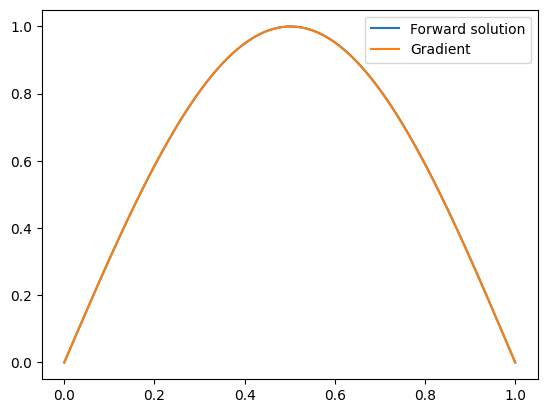

In [ ]:
schedule = SingleDiskStorageSchedule(move_data=True)  # Create the checkpointing schedule.
burger = BurgersEquation(model, u0, mesh)  # Create the burger's equation object.
manager = CheckpointingManager(schedule, burger)  # Create the checkpointing manager.
manager.execute()  # execute the checkpointing schedule using `SingleMemoryStorageSchedule` schedule.
E, epsilon = taylor_remainder_test(burger.gradient(), J, u0, h)  # Compute the Taylor remainder.
convergence_rates(E, epsilon, show=True)
plot_solution(burger.forward_final_solution, burger.gradient())


The following example uses `Revolve` schedule [1]. The `Revolve` algorithm requires the definition of the maximal step `model["max_n"]` before the execution of the forward solver, and also the specification of the number of checkpoints stored in memory.

6.299475166464674 6.299482798448341
6.299450848246124 6.299482798448341
6.299438688870396 6.299482798448341
6.29943260832988 6.299482798448341
Computed convergence rates: [-1.0656950732174286, 0.5347331058754792, 0.8136886051131703]


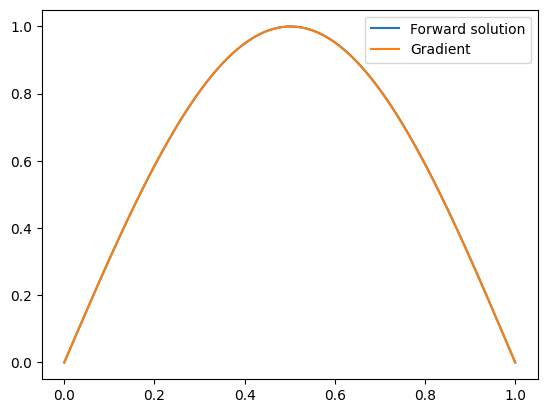

In [ ]:
burger = BurgersEquation(model, u0, mesh) # create the burger's equation object
schedule = Revolve(model["max_n"], model["chk_ram"]) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
E, epsilon = taylor_remainder_test(burger.gradient(), J, u0, h)  # Compute the Taylor remainder.
convergence_rates(E, epsilon, show=True)
plot_solution(burger.forward_final_solution, burger.gradient())

Feel free to explore alternative schedules provided by the `checkpoint_schedules` package. Our [notebook with illustrative example](https://nbviewer.org/github/firedrakeproject/checkpoint_schedules/blob/main/docs/notebooks/tutorial.ipynb) offers a demonstration of their usage. You need follow the steps outlined in the above code: instantiate a `BurgersEquation` object, define the `schedule`, create a `CheckpointingManager` object, and then execute the solvers using the `execute` method.

### References

[1] Griewank, A., & Walther, A. (2000). Algorithm 799: revolve: an implementation of checkpointing for the reverse or adjoint mode of computational differentiation. ACM Transactions on Mathematical Software (TOMS), 26(1), 19-45., doi: https://doi.org/10.1145/347837.347846